<a href="https://colab.research.google.com/github/rhwy12/AI_TeamProject/blob/main/AI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

%matplotlib inline

now = datetime.now()

In [ ]:
code_name = '005930'
start_day = "2017-01-01"
end_day = datetime.now()
predict_day = now + timedelta(weeks=1) # 1주일 후 예측

last_days = 10

In [ ]:
datas = web.DataReader(code_name, 'naver', start=start_day, end=end_day)
datas.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-02,35980,36240,35880,36100,93012
2017-01-03,36280,36620,36020,36480,147153
2017-01-04,36500,36520,36100,36160,159435
2017-01-05,36060,36060,35540,35560,219349
2017-01-06,36180,36440,36040,36200,177619


In [ ]:
datas.shape

(1318, 5)

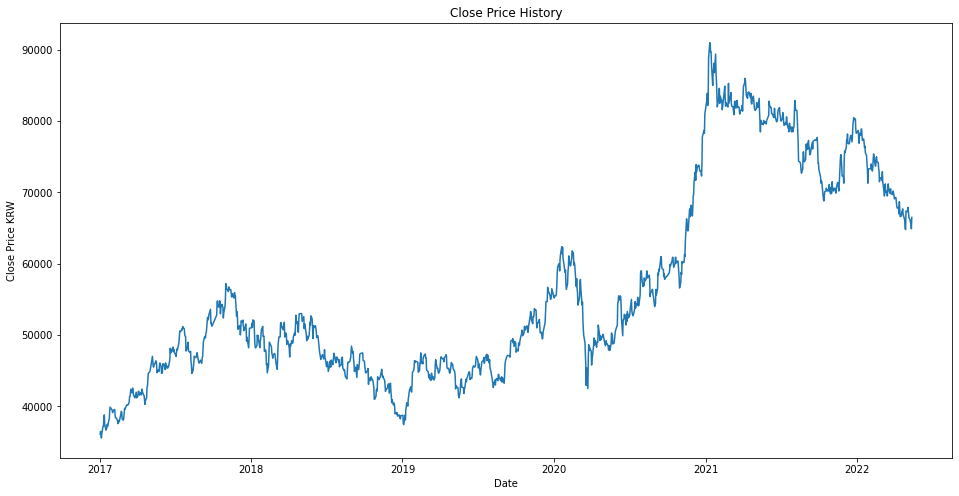

In [ ]:
plt.figure(figsize=(16,8))

plt.title('Close Price History')

plt.plot(datas['Close'].astype('float32'))

plt.xlabel('Date')

plt.ylabel('Close Price KRW')

plt.show()

In [ ]:
data = datas.filter(['Close'])

In [ ]:
dataset = data.values

In [ ]:
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1055

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00974026],
       [0.01659452],
       [0.01082251],
       ...,
       [0.54365079],
       [0.52922078],
       [0.55808081]])

In [ ]:
train_data = scaled_data[0:training_data_len, :]

In [ ]:
x_train = []

y_train = []

for i in range(last_days, len(train_data)):

    x_train.append(train_data[i-last_days:i, 0])

    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # three-dimensional shape

x_train.shape


(1045, 10, 1)

In [ ]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(LSTM(50, return_sequences=False))

model.add(Dense(25))

model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

1045/1045 [==============================] - 23s 8ms/step - loss: 0.0030


In [ ]:
test_data = scaled_data[training_data_len - last_days:,:]

In [ ]:
x_test = []

y_test = dataset[training_data_len:,:]

for i in range(last_days, len(test_data)):

    x_test.append(test_data[i-last_days:i,0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)

predictions

array([[87859.05 ],
       [87623.93 ],
       [87384.37 ],
       [87220.08 ],
       [87159.4  ],
       [87047.47 ],
       [86864.75 ],
       [86617.164],
       [86345.055],
       [86119.63 ],
       [85980.76 ],
       [85938.23 ],
       [85883.695],
       [85937.67 ],
       [85817.96 ],
       [85553.586],
       [85099.51 ],
       [84735.25 ],
       [84377.875],
       [84039.4  ],
       [83692.87 ],
       [83469.625],
       [83295.13 ],
       [83115.95 ],
       [83063.87 ],
       [83057.24 ],
       [83155.87 ],
       [83225.98 ],
       [83354.61 ],
       [83511.13 ],
       [83876.91 ],
       [84229.39 ],
       [84561.73 ],
       [84840.16 ],
       [84997.65 ],
       [85077.15 ],
       [85078.61 ],
       [84983.02 ],
       [84891.83 ],
       [84890.914],
       [84762.33 ],
       [84628.23 ],
       [84437.195],
       [84232.836],
       [84078.95 ],
       [84053.586],
       [84131.04 ],
       [84310.875],
       [84409.984],
       [84407.75 ],


In [ ]:
train = data[:training_data_len]

valid = data[training_data_len:].copy().astype('float32')

valid['Predictions'] = predictions

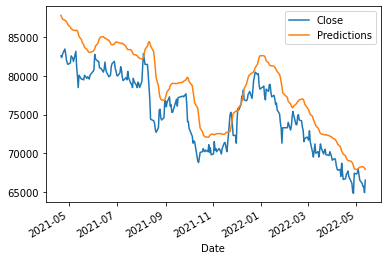

In [ ]:
valid.plot()

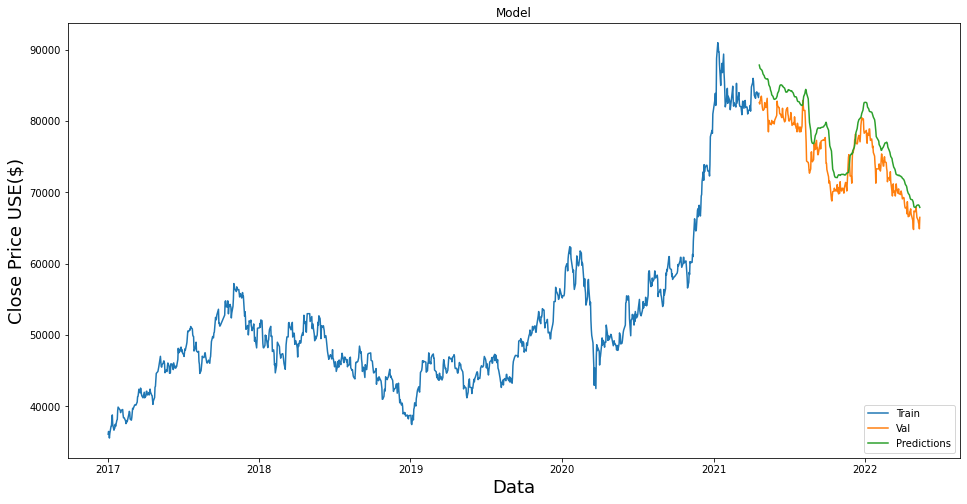

In [ ]:
plt.figure(figsize=(16,8))

plt.title('Model')

plt.xlabel('Data', fontsize=18)

plt.ylabel('Close Price USE($)', fontsize=18)

plt.plot(train['Close'].astype('float32'))

plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

In [ ]:
# 컬럼 ds(YYYY-MM-DD), y(종가 : Close) 구성
# 해당 구저의 DateFrame만들기 위한 딕셔너리 선언

dic = {
    'ds' : datas.index,
    'y' : datas.Close
}

# ds 와 y를 컬럼으로 갖는 데이터 프레임 생성
df = pd.DataFrame( dic )

#인덱스 초기화(원본 까지 적용)
df.reset_index( inplace=True )

# 'ds' 컬럼과 중복되는 'Date' 컬럼 제거
del df['Date']

# 페이스북의 시계열 예측 모델에 사용한 데이터 준비
df.head(5)

,ds,y
0,2017-01-02,36100
1,2017-01-03,36480
2,2017-01-04,36160
3,2017-01-05,35560
4,2017-01-06,36200


In [ ]:
# prophet 모듈 세팅
from fbprophet import Prophet

# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
model = Prophet( daily_seasonality=True ) 

# 데이터 학습 시작 -> 기계학습
model.fit( df )

# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 7일치 예측값
future = model.make_future_dataframe( periods=9 )

# 주가 예측
forecast = model.predict( future )

# forecast.columns ->
'''
  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
''' 

# 필요한 컬럼만 보기
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1317,2022-05-13,66284.707707,63107.309118,69355.508478
1318,2022-05-14,66602.243548,63444.558449,69527.173519
1319,2022-05-15,66519.949189,63330.920928,69547.581746
1320,2022-05-16,66057.294110,63000.517483,69578.412582
1321,2022-05-17,66110.997334,62814.722792,69201.867835
1322,2022-05-18,66002.535979,62921.787637,68978.547433
1323,2022-05-19,65969.021003,62699.844265,69049.358109
1324,2022-05-20,65831.901382,62582.870490,68963.555910
1325,2022-05-21,66211.006420,62989.776225,69391.752732
1326,2022-05-22,66192.143760,63113.002596,69134.053746
